<a href="https://colab.research.google.com/github/jkeza1/Maternal_Health_Summative/blob/main/Summative_Intro_to_ml_Keza_Joan_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Optimization Techniques in Machine Learning

Objective: This assignment aims to explore implementation or Machine Learning Models with regularization, optimization and Error analysis  techniques used in machine learning to improve models' performance, convergence speed, and efficiency..

A Notebook detailing the following

* Project name
* Clear out puts from cells






**Instructions**

1. Acquire a dataset suitable for ML tasks as per your proposal.
2. Implement a simple machine learning model based on neural networks on the chosen dataset without any defined optimization techniques. (Check instructions)
3. Implement and compare the model's performance after applying 3 to 4 disntict combinations regularization and optimization techniques.
4. Discuss the results on the README file.
5. Make predictions using test data
7. Implement error analysis techniques and ensure there is: F1-Score, Recall, Precision, RUC a confusion matrix using plotting libraries (not verbose)

Submit notebook to github repo




# Case Study and Implementation




In [63]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import (accuracy_score, f1_score, precision_score, recall_score,
                           classification_report, confusion_matrix, ConfusionMatrixDisplay,
                           roc_curve, auc)
from joblib import dump
from sklearn.datasets import make_classification

# TensorFlow/Keras imports
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Input, BatchNormalization
from tensorflow.keras.optimizers import Adam, Nadam, RMSprop, SGD
from tensorflow.keras.regularizers import l1, l2, l1_l2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model
from tensorflow.keras.initializers import HeNormal
from typing import Literal, Optional
import absl.logging
absl.logging.set_verbosity(absl.logging.ERROR)

# The Dataset
Problem Statement
Unplanned pregnancies among single mothers in Rwanda contribute to cycles of poverty, school dropouts, and poor health outcomes. While existing platforms (e.g., RapidSMS, Babyl Rwanda) provide general health tracking, they lack personalized, predictive tools for vulnerable women. Current AI solutions in maternal health rely on hospital-grade data, making them ineffective for community-level interventions in low-resource settings like Rwanda.

This project aims to:
1. Predict pregnancy risk within the next year using locally relevant data

2. Integrate with Rwanda’s SMEEF platform for proactive interventions

3. Empower single mothers through early, data-driven support

Dataset Description
The model will leverage health and lifestyle data from Rwandan women, including:

Key Features (Examples)
Demographics: Age, marital status, education level

Health Metrics:

Menstrual cycle regularity

Contraceptive use (type, consistency)

Existing medical conditions (e.g., anemia, hypertension)

Behavioral/Socioeconomic Factors:

Access to healthcare

Employment status

Household size

Geographic location (urban/rural)

Target Variable
Binary Classification:

1: High risk of pregnancy in the next 12 months

0: Low risk


In [64]:
df = pd.read_csv('/content/Maternal Health Risk Data Set.csv')


In [65]:
df['BP_Ratio'] = df['SystolicBP'] / (df['DiastolicBP'] + 1e-5)  # Avoid division by zero
df['Temp_HR_Product'] = df['BodyTemp'] * df['HeartRate']

In [66]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df['RiskLevel'] = le.fit_transform(df['RiskLevel'])  # 0=Low, 1=Medium, 2=High

In [67]:
X = df.drop('RiskLevel', axis=1)
y = df['RiskLevel']

In [98]:
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42,

)


X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val,
    test_size=0.25,
    stratify=y_train_val,
    random_state=42
)


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)


In [99]:
print("Shapes after splitting and scaling:")
print(f"- Training: {X_train_scaled.shape}")
print(f"- Validation: {X_val_scaled.shape}")
print(f"- Test: {X_test_scaled.shape}")

Shapes after splitting and scaling:
- Training: (6000, 20)
- Validation: (2000, 20)
- Test: (2000, 20)


In [101]:

input_shape = (X_train_scaled.shape[1],)

# Basic model
basic_model, basic_callbacks = build_high_accuracy_model(
    input_shape=input_shape,
    optimizer='adam',
    hidden_layers=2,
    use_batch_norm=False,
    dropout_rate=0.2
)

# Optimized model
optimized_model, opt_callbacks = build_high_accuracy_model(
    input_shape=input_shape,
    optimizer='nadam',
    learning_rate=0.0005,
    lr_scheduling=True,
    dropout_rate=0.3,
    l2_reg=0.0005,
    use_batch_norm=True,
    hidden_layers=4,
    layer_size=256,
    activation='swish'
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [153]:
# 2. Define and train the RandomForest with GridSearch
# =============================================================================
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from joblib import dump

print(f"Training data shape: {X_train_scaled.shape}")
# Define the model and parameter grid
rf_model = RandomForestClassifier(random_state=42)

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'max_features': ['sqrt', 'log2']
}

# Create GridSearchCV object
rf_grid = GridSearchCV(
    estimator=rf_model,
    param_grid=param_grid,
    cv=5,
    scoring='f1_weighted',
    verbose=1,
    n_jobs=-1
)

Training data shape: (6000, 20)


In [72]:
print("Training RandomForest with GridSearch...")
rf_grid.fit(X_train_scaled_orig, y_train_orig)

Training RandomForest with GridSearch...
Fitting 5 folds for each of 24 candidates, totalling 120 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [None, 10, 20],
                         'max_features': ['sqrt', 'log2'],
                         'min_samples_split': [2, 5],
                         'n_estimators': [100, 200]},
             scoring='f1_weighted', verbose=1)

In [73]:
best_rf = rf_grid.best_estimator_
print(f"\nBest Parameters: {rf_grid.best_params_}")


Best Parameters: {'max_depth': 20, 'max_features': 'log2', 'min_samples_split': 2, 'n_estimators': 100}


In [74]:
y_pred_rf = best_rf.predict(X_test_scaled)
print("\nRandomForest Performance:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred_rf, average='weighted'):.4f}")


RandomForest Performance:
Accuracy: 0.8670
F1-Score: 0.8681


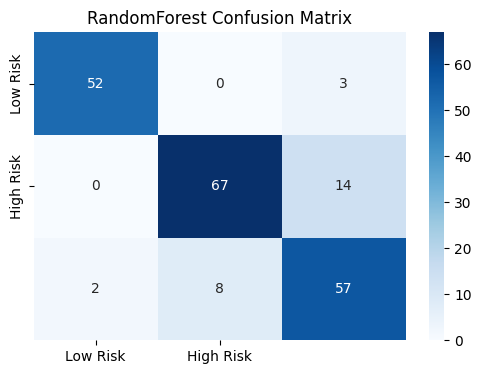

In [75]:
plt.figure(figsize=(6, 4))
cm = confusion_matrix(y_test_orig, y_pred_rf)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Low Risk', 'High Risk'],
            yticklabels=['Low Risk', 'High Risk'])
plt.title('RandomForest Confusion Matrix')
plt.show()

In [76]:
# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf,
                          target_names=['Low Risk', 'Medium Risk', 'High Risk']))


Classification Report:
              precision    recall  f1-score   support

    Low Risk       0.96      0.95      0.95        55
 Medium Risk       0.89      0.83      0.86        81
   High Risk       0.77      0.85      0.81        67

    accuracy                           0.87       203
   macro avg       0.88      0.87      0.87       203
weighted avg       0.87      0.87      0.87       203



In [77]:
# Save the model
dump(best_rf, 'best_randomforest.joblib')
print("Model saved as 'best_randomforest.joblib'")

Model saved as 'best_randomforest.joblib'


#SECTION 1: Model Architecture:



```
TODO: Insert an image with the Model architecture here.Replace the image Below
```
> <img src="https://miro.medium.com/v2/resize:fit:640/format:webp/1*v1ohAG82xmU6WGsG2hoE8g.png" alt="?" style="width:25px"/>




#Task: Define a function that creates models without and With specified Optimization techniques


In [107]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.callbacks import EarlyStopping

def define_model(input_shape,
                 optimizer_name='adam',
                 regularization_type=None,
                 early_stopping=False,
                 dropout=0.0,
                 learning_rate=0.001,
                 epochs=20,
                 X_train=None,
                 y_train=None,
                 X_val=None,
                 y_val=None,
                 model_name='model'):

    # Define regularizer
    regularizer = None
    if regularization_type == 'l1':
        regularizer = l1(0.01)
    elif regularization_type == 'l2':
        regularizer = l2(0.01)

    # Choose optimizer
    if optimizer_name.lower() == 'adam':
        optimizer = Adam(learning_rate=learning_rate)
    elif optimizer_name.lower() == 'rmsprop':
        optimizer = RMSprop(learning_rate=learning_rate)
    else:
        raise ValueError("Unsupported optimizer. Use 'adam' or 'rmsprop'.")

    # Build model
    model = Sequential()
    model.add(Dense(64, activation='relu', input_shape=input_shape, kernel_regularizer=regularizer))
    if dropout > 0:
        model.add(Dropout(dropout))
    model.add(Dense(32, activation='relu', kernel_regularizer=regularizer))
    model.add(Dense(1, activation='sigmoid'))

    num_layers = 3

    # Compile model
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    # Callbacks
    callbacks = []
    if early_stopping:
        callbacks.append(EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True))

    # Train model
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        callbacks=callbacks,
        verbose=1
    )

    config = {
        'model_name': model_name,
        'optimizer_name': optimizer_name,
        'regularization_type': regularization_type,
        'early_stopping': early_stopping,
        'dropout': dropout,
        'learning_rate': learning_rate,
        'epochs_planned': epochs,
        'epochs_trained': len(history.history['loss']),
        'num_layers': num_layers,
        'history': history.history
    }

    return model, history, config


In [108]:
model1, history1, config1 = define_model(
    input_shape=(X_train_scaled.shape[1],),
    optimizer_name='adam',
    regularization_type=None,
    early_stopping=False,
    dropout=0,
    learning_rate=0.001,
    epochs=20,
    X_train=X_train_scaled,
    y_train=y_train,
    X_val=X_val_scaled,
    y_val=y_val,
    model_name='model1_baseline'
)


Epoch 1/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7540 - loss: 0.4960 - val_accuracy: 0.8850 - val_loss: 0.2966
Epoch 2/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8947 - loss: 0.2846 - val_accuracy: 0.9045 - val_loss: 0.2690
Epoch 3/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9074 - loss: 0.2679 - val_accuracy: 0.9170 - val_loss: 0.2487
Epoch 4/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9273 - loss: 0.2318 - val_accuracy: 0.9230 - val_loss: 0.2414
Epoch 5/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9253 - loss: 0.2250 - val_accuracy: 0.9255 - val_loss: 0.2338
Epoch 6/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9344 - loss: 0.2220 - val_accuracy: 0.9290 - val_loss: 0.2292
Epoch 7/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9375 - loss: 0.2063 - val_accuracy: 0.9270 - val_loss: 0.2282
Epoch 8/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9435 - loss: 0.1896 - val_accuracy: 0.

In [109]:
def make_predictions_with_metrics(model_path, X, y_true=None):
    """
    Loads a model from file and computes predictions and optional accuracy.
    """
    result = {
        'predictions': None,
        'accuracy': None,
        'error': None
    }

    if model_path is None or not isinstance(model_path, (str, bytes, os.PathLike)):
        result['error'] = "Invalid model path"
        return result

    if not os.path.exists(model_path):
        result['error'] = f"Model file not found at {model_path}"
        return result

    try:
        model = load_model(model_path)
        predictions_prob = model.predict(X, verbose=0)
        predictions = (predictions_prob > 0.5).astype(int)
        result['predictions'] = predictions

        if y_true is not None:
            result['accuracy'] = accuracy_score(y_true, predictions)

    except Exception as e:
        result['error'] = f"Prediction failed: {str(e)}"

    return result


In [112]:
# ✅ Instance 1: Baseline model (no optimizations)
model1, history1, config1 = define_model(input_shape=(X_train_scaled.shape[1],),
    optimizer_name='adam',
    regularization_type=None,
    early_stopping=False,
    dropout=0.0,
    learning_rate=0.001,
    epochs=20,
    X_train=X_train_scaled,
    y_train=y_train,
    X_val=X_val_scaled,
    y_val=y_val,
    model_name='model1_baseline'
)

model1.save('saved_models/model1_baseline.h5', include_optimizer=False)


Epoch 1/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.7718 - loss: 0.4970 - val_accuracy: 0.8840 - val_loss: 0.3037
Epoch 2/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8902 - loss: 0.2835 - val_accuracy: 0.8990 - val_loss: 0.2758
Epoch 3/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9073 - loss: 0.2677 - val_accuracy: 0.9105 - val_loss: 0.2575
Epoch 4/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9177 - loss: 0.2476 - val_accuracy: 0.9160 - val_loss: 0.2475
Epoch 5/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9336 - loss: 0.2301 - val_accuracy: 0.9245 - val_loss: 0.2387
Epoch 6/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9307 - loss: 0.2244 - val_accuracy: 0.9265 - val_loss: 0.2378
Epoch 7/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9357 - loss: 0.2180 - val_accuracy: 0.9255 - val_loss: 0.2323
Epoch 8/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9355 - loss: 0.2168 - val_accuracy: 0.

# Task: Print out the Final Model Accuracy and plot the Loss curve

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Final Validation Accuracy: 0.9280


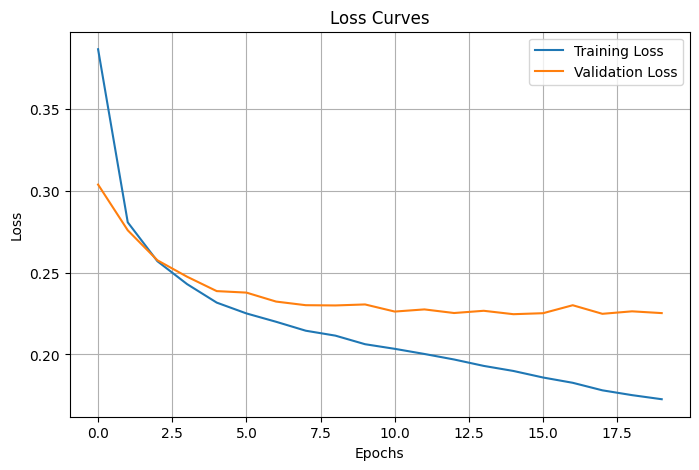

In [117]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

# 1. Predict on validation data and calculate accuracy
y_val_pred_prob = model1.predict(X_val_scaled)
y_val_pred = (y_val_pred_prob > 0.5).astype(int)
val_accuracy = accuracy_score(y_val, y_val_pred)

print(f"Final Validation Accuracy: {val_accuracy:.4f}")

# 2. Plot training and validation loss curves
plt.figure(figsize=(8, 5))
plt.plot(history1.history['loss'], label='Training Loss')
plt.plot(history1.history['val_loss'], label='Validation Loss')
plt.title('Loss Curves')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


In [126]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             classification_report, confusion_matrix)

def evaluate_model(model, X_val, y_val, config=None):
    # Get predictions (probabilities -> binary)
    preds = model.predict(X_val)
    y_pred = (preds > 0.5).astype(int).flatten()  # flatten if shape is (n,1)

    # Safely access config with defaults
    def get_config(key, default='N/A'):
        if config and key in config:
            return config[key]
        return default

    # Collect metrics
    metrics = {
        'Model Name': get_config('model_name', 'unnamed_model'),
        'Optimizer': get_config('optimizer_name', 'N/A'),
        'Regularizer': get_config('regularization_type', 'None'),
        'Early Stopping': 'Yes' if get_config('early_stopping', False) else 'No',
        'Learning Rate': get_config('learning_rate', 'N/A'),
        'Epochs Planned': get_config('epochs_planned', 'N/A'),
        'Epochs Trained': get_config('epochs_trained', 'N/A'),
        'Num Layers': get_config('num_layers', 'N/A'),
        'Dropout': get_config('dropout', 0),
        'Accuracy': accuracy_score(y_val, y_pred),
        'Precision': precision_score(y_val, y_pred, zero_division=0),
        'Recall': recall_score(y_val, y_pred, zero_division=0),
        'F1 Score': f1_score(y_val, y_pred, zero_division=0),
        'Training Accuracy': get_config('history', {}).get('accuracy', [None])[-1],
        'Validation Accuracy': get_config('history', {}).get('val_accuracy', [None])[-1],
        'Training Loss': get_config('history', {}).get('loss', [None])[-1],
        'Validation Loss': get_config('history', {}).get('val_loss', [None])[-1]
    }

    # Print classification report
    print(f"\n=== Evaluation Metrics for {metrics['Model Name']} ===")
    print("\nClassification Report:\n", classification_report(y_val, y_pred))
    print("\nDetailed Metrics:")
    for k, v in metrics.items():
        if isinstance(v, float):
            print(f"{k}: {v:.4f}")
        else:
            print(f"{k}: {v}")

    # Plot confusion matrix
    cm = confusion_matrix(y_val, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Negative', 'Positive'],
                yticklabels=['Negative', 'Positive'])
    plt.title(f"Confusion Matrix - {metrics['Model Name']}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    return None


In [127]:
import matplotlib.pyplot as plt

def plot_loss_curves(history):
    plt.figure(figsize=(8, 5))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()


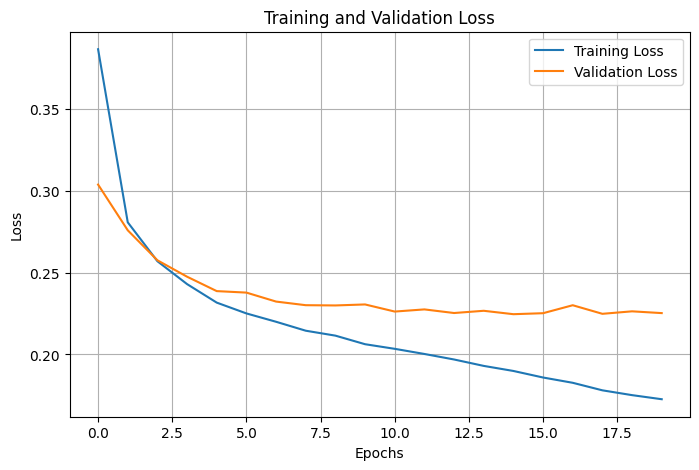

In [128]:
plot_loss_curves(history1)


In [129]:
evaluate_model(model1, X_val_scaled, y_val, config=config1)


63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

=== Evaluation Metrics for model1_baseline ===

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.92      0.93      1001
           1       0.92      0.93      0.93       999

    accuracy                           0.93      2000
   macro avg       0.93      0.93      0.93      2000
weighted avg       0.93      0.93      0.93      2000


Detailed Metrics:
Model Name: model1_baseline
Optimizer: adam
Regularizer: None
Early Stopping: No
Learning Rate: 0.0010
Epochs Planned: 20
Epochs Trained: 20
Num Layers: 3
Dropout: 0.0000
Accuracy: 0.9280
Precision: 0.9237
Recall: 0.9329
F1 Score: 0.9283
Training Accuracy: 0.9438
Validation Accuracy: 0.9280
Training Loss: 0.1727
Validation Loss: 0.2253


# SECTION 2: Optimization and Regularization Combinations
At this point you should now create models that combine various optimization techniques
As done before make sure to plot out the loss curve and the accuracy and loss in verbose

In [118]:
# ✅ Instance 2
model2, history2, config2 = define_model(input_shape=(X_train_scaled.shape[1],),
    optimizer_name='adam',
    regularization_type='l2',
    early_stopping=True,
    dropout=0.3,
    learning_rate=0.0005,
    epochs=30,
    X_train=X_train_scaled,
    y_train=y_train,
    X_val=X_val_scaled,
    y_val=y_val,
    model_name='model2_opt_l2_dropout'
)

model2.save('saved_models/model2_opt_l2_dropout.h5', include_optimizer=False)


Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


188/188 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.7257 - loss: 1.2384 - val_accuracy: 0.8740 - val_loss: 0.8311
Epoch 2/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.8591 - loss: 0.7819 - val_accuracy: 0.8905 - val_loss: 0.6065
Epoch 3/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8840 - loss: 0.5921 - val_accuracy: 0.8940 - val_loss: 0.4936
Epoch 4/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8972 - loss: 0.4803 - val_accuracy: 0.9015 - val_loss: 0.4271
Epoch 5/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9043 - loss: 0.4126 - val_accuracy: 0.9065 - val_loss: 0.3846
Epoch 6/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9004 - loss: 0.3851 - val_accuracy: 0.9095 - val_loss: 0.3547
Epoch 7/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9069 - loss: 0.3568 - val_accuracy: 0.9145 - val_loss: 0.3343
Epoch 8/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9138 - loss: 0.3364 - val_accuracy: 0.9135 - va

In [130]:
# Get the final training loss (last epoch)
final_train_loss = history2.history['loss'][-1]

# Get the final validation loss (last epoch)
final_val_loss = history2.history['val_loss'][-1]

print(f"Final Training Loss: {final_train_loss:.4f}")
print(f"Final Validation Loss: {final_val_loss:.4f}")


Final Training Loss: 0.2680
Final Validation Loss: 0.2593


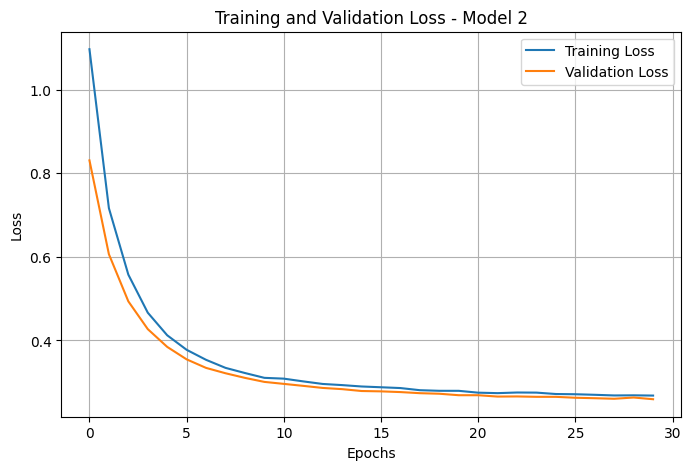

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Classification Report for Model 2:
              precision    recall  f1-score   support

           0       0.95      0.91      0.93      1001
           1       0.91      0.95      0.93       999

    accuracy                           0.93      2000
   macro avg       0.93      0.93      0.93      2000
weighted avg       0.93      0.93      0.93      2000



In [138]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import numpy as np

plt.figure(figsize=(8,5))
plt.plot(history2.history['loss'], label='Training Loss')
plt.plot(history2.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss - Model 2')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Predict probabilities
y_pred_prob = model2.predict(X_val_scaled)

# Convert probabilities to class predictions (assuming binary classification with sigmoid output)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()

# Print classification report
print("Classification Report for Model 2:")
print(classification_report(y_val, y_pred))



In [119]:
# ✅ Instance 3
model3, history3, config3 = define_model(input_shape=(X_train_scaled.shape[1],),
    optimizer_name='rmsprop',
    regularization_type='l1',   # L1 regularization
    early_stopping=False,       # ❌ Early stopping disabled
    dropout=0.2,
    learning_rate=0.0008,
    epochs=25,
    X_train=X_train_scaled,
    y_train=y_train,
    X_val=X_val_scaled,
    y_val=y_val,
    model_name='model3_opt_l1_rmsprop'
)

model3.save('saved_models/model3_opt_l1_rmsprop.h5', include_optimizer=False)


Epoch 1/25
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6822 - loss: 3.8708 - val_accuracy: 0.8730 - val_loss: 1.5205
Epoch 2/25
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8731 - loss: 1.1319 - val_accuracy: 0.8870 - val_loss: 0.5494
Epoch 3/25
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8911 - loss: 0.5231 - val_accuracy: 0.8880 - val_loss: 0.4751
Epoch 4/25
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8904 - loss: 0.4755 - val_accuracy: 0.8935 - val_loss: 0.4493
Epoch 5/25
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8863 - loss: 0.4623 - val_accuracy: 0.8920 - val_loss: 0.4334
Epoch 6/25
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8873 - loss: 0.4487 - val_accuracy: 0.8945 - val_loss: 0.4244
Epoch 7/25
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8851 - loss: 0.4394 - val_accuracy: 0.8935 - val_loss: 0.4199
Epoch 8/25
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8845 - loss: 0.4466 - val_accuracy: 0.

In [132]:
# Final training loss
final_train_loss_3 = history3.history['loss'][-1]

# Final validation loss
final_val_loss_3 = history3.history['val_loss'][-1]

print(f"Final Training Loss (Model 3): {final_train_loss_3:.4f}")
print(f"Final Validation Loss (Model 3): {final_val_loss_3:.4f}")


Final Training Loss (Model 3): 0.3988
Final Validation Loss (Model 3): 0.3734


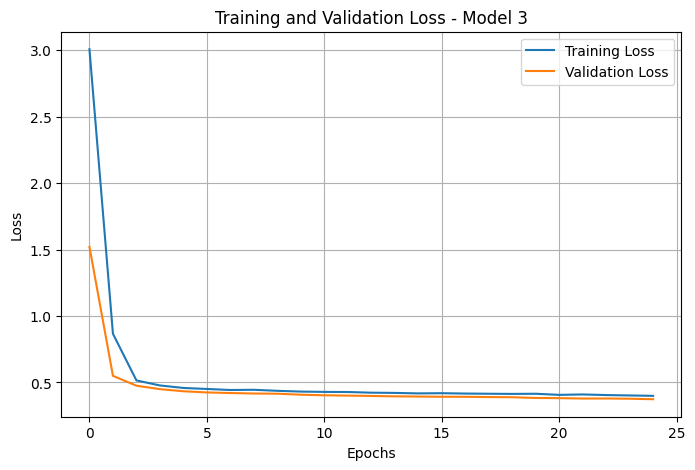

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Classification Report for Model 3:
              precision    recall  f1-score   support

           0       0.90      0.90      0.90      1001
           1       0.90      0.90      0.90       999

    accuracy                           0.90      2000
   macro avg       0.90      0.90      0.90      2000
weighted avg       0.90      0.90      0.90      2000



In [137]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import numpy as np

plt.figure(figsize=(8,5))
plt.plot(history3.history['loss'], label='Training Loss')
plt.plot(history3.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss - Model 3')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Predict probabilities
y_pred_prob = model3.predict(X_val_scaled)

# Convert probabilities to class predictions (assuming binary classification with sigmoid output)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()

# Print classification report
print("Classification Report for Model 3:")
print(classification_report(y_val, y_pred))



In [120]:
# ✅ Instance 4
model4, history4, config4 = define_model(input_shape=(X_train_scaled.shape[1],),
    optimizer_name='adam',
    regularization_type='l2',
    early_stopping=True,
    dropout=0.4,
    learning_rate=0.0003,
    epochs=35,
     X_train=X_train_scaled,
    y_train=y_train,
    X_val=X_val_scaled,
    y_val=y_val,
    model_name='model4_opt_deep_l2'
)

model4.save('saved_models/model4_opt_deep_l2.h5', include_optimizer=False)


Epoch 1/35
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5958 - loss: 1.3341 - val_accuracy: 0.8415 - val_loss: 1.0495
Epoch 2/35
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8176 - loss: 0.9959 - val_accuracy: 0.8745 - val_loss: 0.7837
Epoch 3/35
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8528 - loss: 0.7706 - val_accuracy: 0.8865 - val_loss: 0.6353
Epoch 4/35
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8813 - loss: 0.6308 - val_accuracy: 0.8880 - val_loss: 0.5484
Epoch 5/35
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8771 - loss: 0.5480 - val_accuracy: 0.8895 - val_loss: 0.4896
Epoch 6/35
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8995 - loss: 0.4752 - val_accuracy: 0.8970 - val_loss: 0.4457
Epoch 7/35
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8919 - loss: 0.4455 - val_accuracy: 0.8970 - val_loss: 0.4135
Epoch 8/35
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8966 - loss: 0.4158 - val_accuracy: 0.

In [134]:
# Final training loss
final_train_loss_4 = history4.history['loss'][-1]

# Final validation loss
final_val_loss_4 = history4.history['val_loss'][-1]

print(f"Final Training Loss (Model 4): {final_train_loss_4:.4f}")
print(f"Final Validation Loss (Model 4): {final_val_loss_4:.4f}")


Final Training Loss (Model 4): 0.2729
Final Validation Loss (Model 4): 0.2658


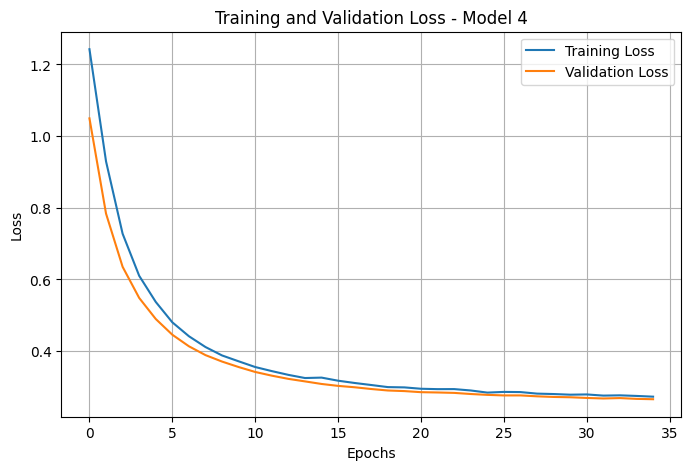

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Classification Report for Model 4:
              precision    recall  f1-score   support

           0       0.93      0.93      0.93      1001
           1       0.93      0.93      0.93       999

    accuracy                           0.93      2000
   macro avg       0.93      0.93      0.93      2000
weighted avg       0.93      0.93      0.93      2000



In [136]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report

plt.figure(figsize=(8,5))
plt.plot(history4.history['loss'], label='Training Loss')
plt.plot(history4.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss - Model 4')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Predict probabilities
y_pred_prob = model4.predict(X_val_scaled)

# Convert probabilities to class predictions (assuming binary classification with sigmoid output)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()

# Print classification report
print("Classification Report for Model 4:")
print(classification_report(y_val, y_pred))



In [139]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

def plot_model_results(model, history, config, X_test, y_test):
    """Plot training curves, confusion matrix, ROC curve, and print classification report for a model."""

    plt.figure(figsize=(15, 10))
    plt.suptitle(f"Results for {config['model_name']}", y=1.02, fontsize=16)

    # Plot training & validation loss
    plt.subplot(2, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Training History - Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot training & validation accuracy
    plt.subplot(2, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title('Training History - Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Confusion matrix
    y_pred = (model.predict(X_test) > 0.5).astype(int)
    cm = confusion_matrix(y_test, y_pred)
    plt.subplot(2, 2, 3)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Class 0', 'Class 1'],
                yticklabels=['Class 0', 'Class 1'])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')

    # ROC curve
    y_pred_proba = model.predict(X_test).ravel()
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    plt.subplot(2, 2, 4)
    plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Print classification report
    print(f"\nClassification Report for {config['model_name']}:")
    print(classification_report(y_test, y_pred, target_names=['Class 0', 'Class 1']))


63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


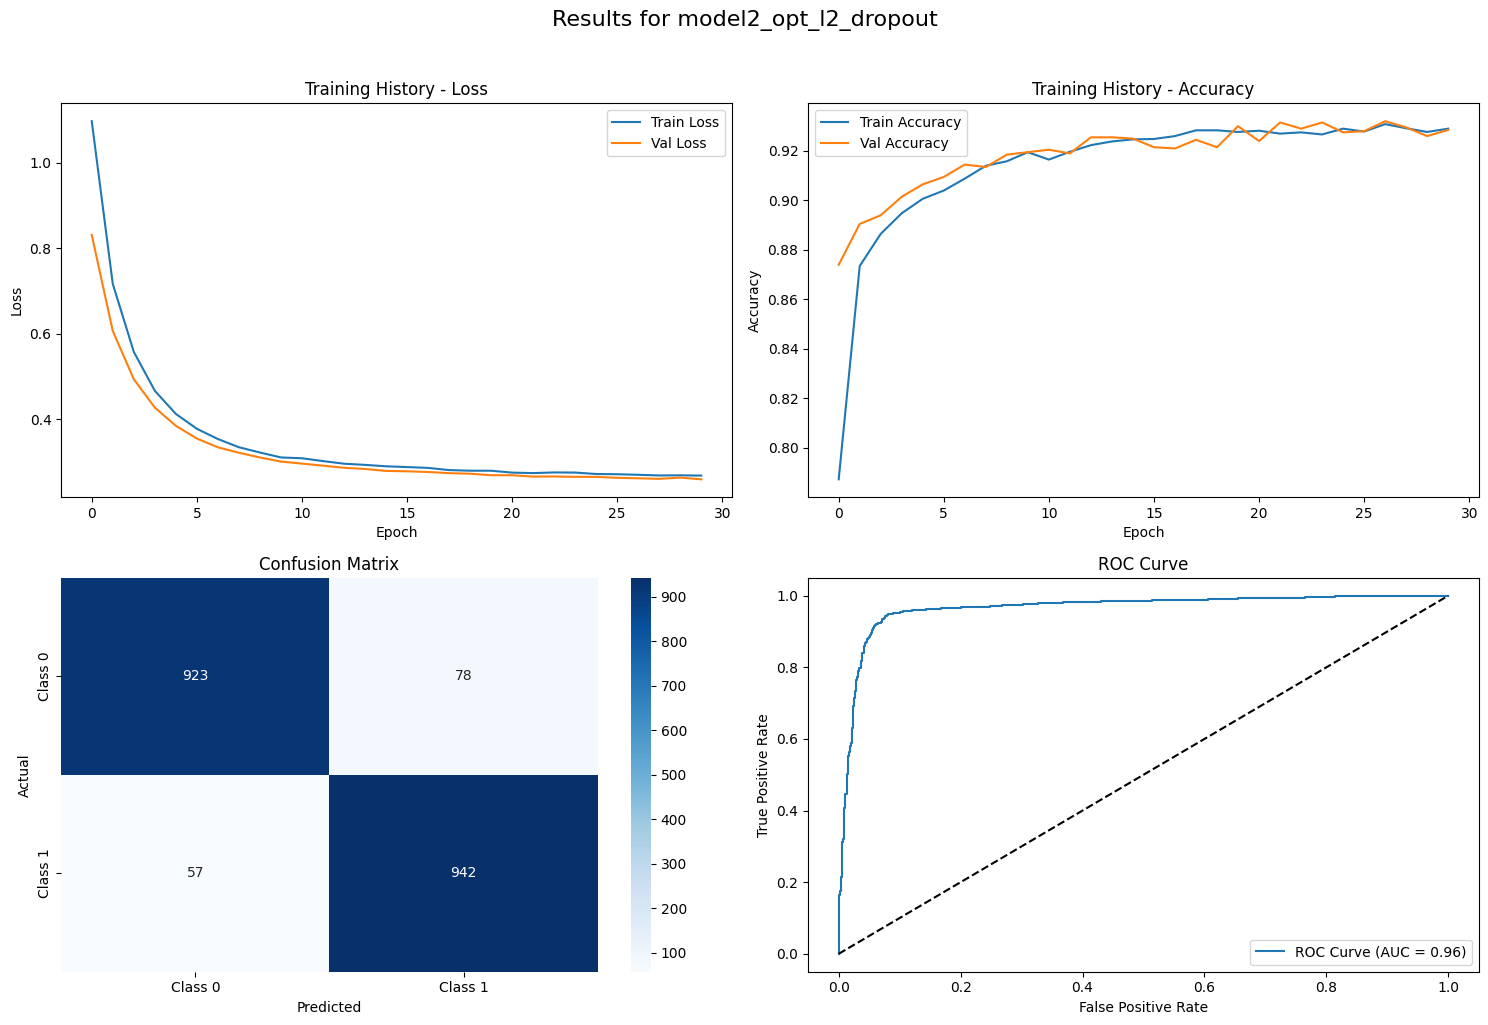


Classification Report for model2_opt_l2_dropout:
              precision    recall  f1-score   support

     Class 0       0.94      0.92      0.93      1001
     Class 1       0.92      0.94      0.93       999

    accuracy                           0.93      2000
   macro avg       0.93      0.93      0.93      2000
weighted avg       0.93      0.93      0.93      2000

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


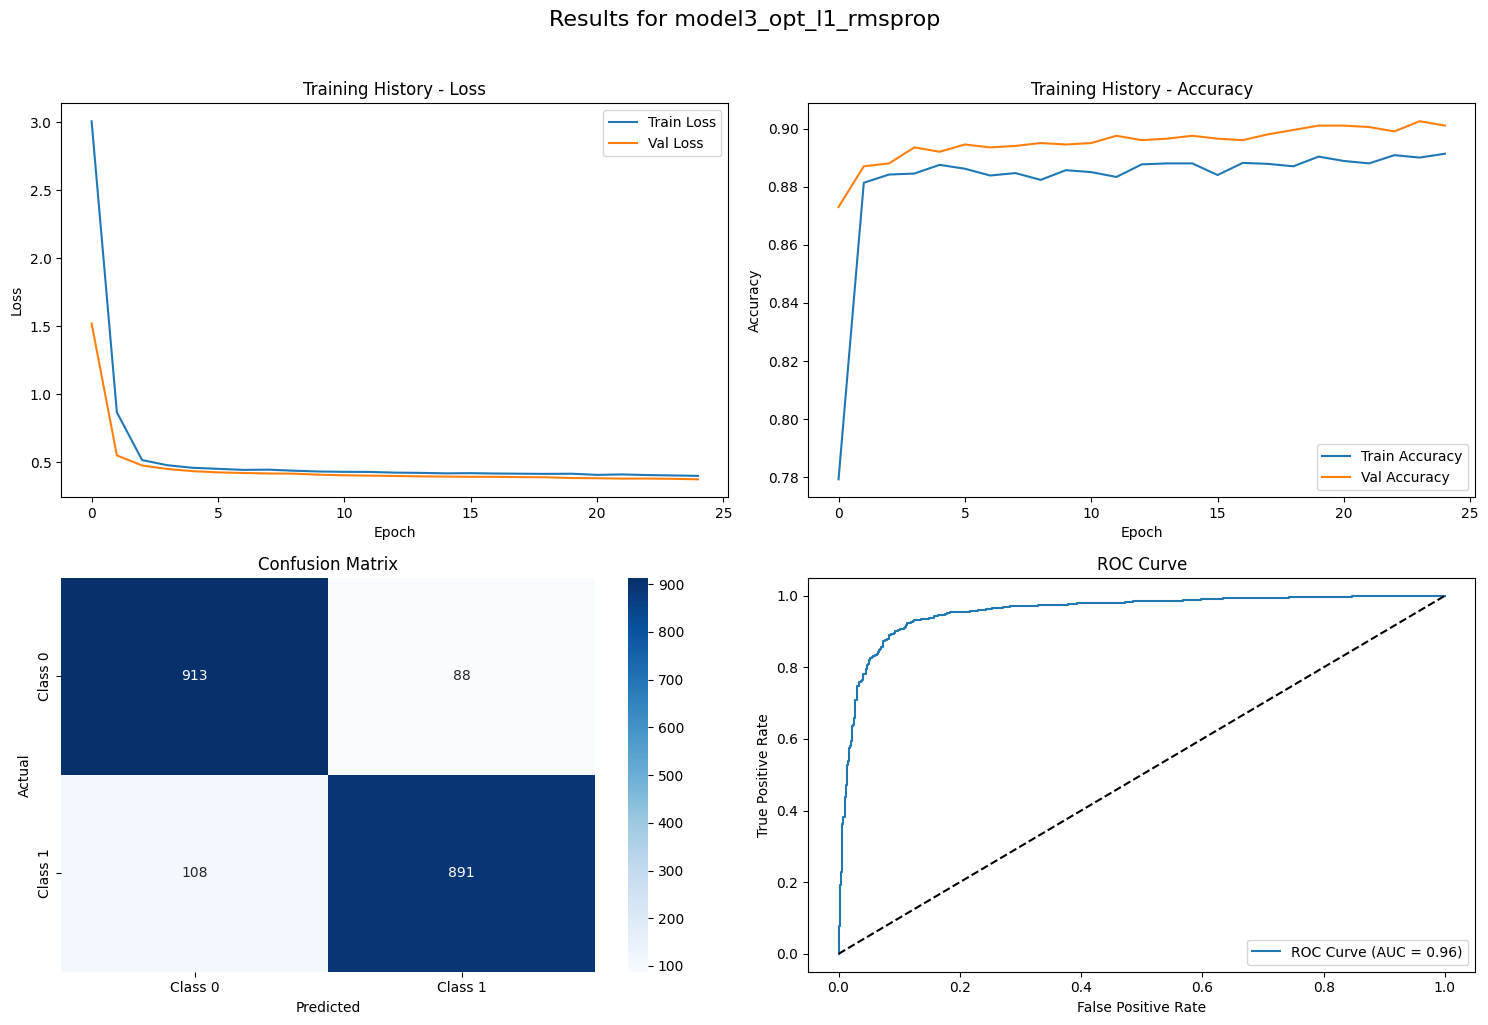


Classification Report for model3_opt_l1_rmsprop:
              precision    recall  f1-score   support

     Class 0       0.89      0.91      0.90      1001
     Class 1       0.91      0.89      0.90       999

    accuracy                           0.90      2000
   macro avg       0.90      0.90      0.90      2000
weighted avg       0.90      0.90      0.90      2000

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


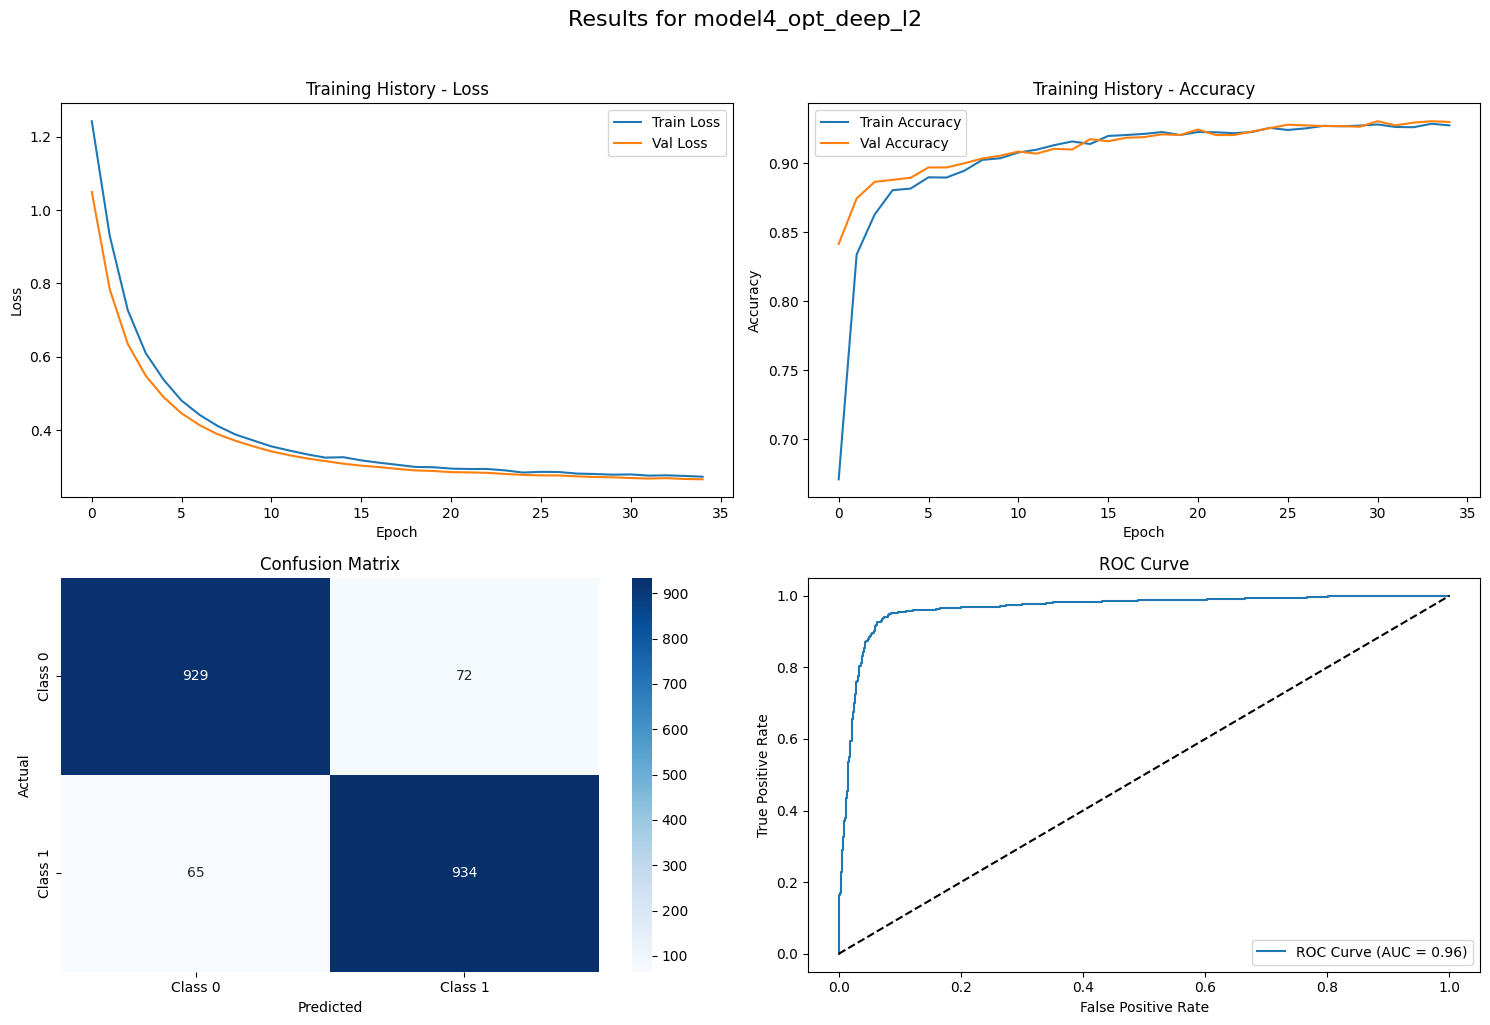


Classification Report for model4_opt_deep_l2:
              precision    recall  f1-score   support

     Class 0       0.93      0.93      0.93      1001
     Class 1       0.93      0.93      0.93       999

    accuracy                           0.93      2000
   macro avg       0.93      0.93      0.93      2000
weighted avg       0.93      0.93      0.93      2000



In [140]:
plot_model_results(model2, history2, config2, X_test_scaled, y_test)
plot_model_results(model3, history3, config3, X_test_scaled, y_test)
plot_model_results(model4, history4, config4, X_test_scaled, y_test)


#Task: Make Predictions using the best saved model


Create a confusion Matrix and F1 score for both Models. Ensure outputs for the cells are visible

Finally, Make predictions using the best model. By the time you get to this cell you may realise at some point you needed to save the model so that you cal load it later

In [154]:
import os
import joblib
import numpy as np
from tensorflow.keras.models import load_model, Model
from sklearn.metrics import accuracy_score

def save_best_model(model, base_path='saved_models/best_model'):
    if isinstance(model, Model):  # Keras model
        save_path = base_path + '.h5'
        model.save(save_path)
        print(f"Keras model saved as '{save_path}'")
    else:  # Sklearn model
        save_path = base_path + '.pkl'
        joblib.dump(model, save_path)
        print(f"Sklearn model saved as '{save_path}'")
    return save_path

# Load your test data (already preprocessed)
# X_test_scaled, y_test = ...

# Load Keras models
model_paths = {
    'model1': 'saved_models/model1_baseline.h5',
    'model2': 'saved_models/model2_opt_l2_dropout.h5',
    'model3': 'saved_models/model3_opt_l1_rmsprop.h5',
    'model4': 'saved_models/model4_opt_deep_l2.h5',
}

keras_models = {name: load_model(path) for name, path in model_paths.items()}

# Load sklearn model if any (adjust filename and extension)
try:
    logistic_model = joblib.load('saved_models/model5_logistic.pkl')
except Exception as e:
    logistic_model = None
    print(f"Could not load sklearn model: {e}")

results = {}

# Evaluate Keras models
for name, model in keras_models.items():
    # Predict classes (binary classification assumed)
    y_pred_prob = model.predict(X_test_scaled)
    y_pred = (y_pred_prob > 0.5).astype(int).flatten()
    acc = accuracy_score(y_test, y_pred)
    results[name] = (acc, model)
    print(f"{name} accuracy: {acc:.4f}")

# Evaluate sklearn model if loaded
if logistic_model:
    y_pred = logistic_model.predict(X_test_scaled)
    acc = accuracy_score(y_test, y_pred)
    results['model5'] = (acc, logistic_model)
    print(f"model5 accuracy: {acc:.4f}")

# Select best model based on accuracy
best_model_name = max(results, key=lambda k: results[k][0])
best_accuracy, best_model = results[best_model_name]

# Save the best model
save_best_model(best_model, base_path='saved_models/best_model')

print(f"\n{best_model_name} is the best model with accuracy = {best_accuracy:.4f}")


Could not load sklearn model: [Errno 2] No such file or directory: 'saved_models/model5_logistic.pkl'
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
model1 accuracy: 0.9295
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
model2 accuracy: 0.9325
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
model3 accuracy: 0.9020
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
model4 accuracy: 0.9315
Keras model saved as 'saved_models/best_model.h5'

model2 is the best model with accuracy = 0.9325


In [155]:
model4.save('best_model.h5')


In [156]:
import os
import joblib
import numpy as np
from tensorflow.keras.models import load_model
from sklearn.preprocessing import StandardScaler

def make_predictions(base_model_path, X_test_scaled, threshold=0.5):
    h5_path = base_model_path + '.h5'
    pkl_path = base_model_path + '.pkl'

    if os.path.exists(h5_path):
        try:
            model = load_model(h5_path)
            probs = model.predict(X_test_scaled, verbose=0)
            preds = (probs > threshold).astype(int).flatten()
            print("✅ Predictions made using Keras model.")
        except Exception as e:
            print("⚠️ Failed to use Keras model. Error:", e)
            model = joblib.load(pkl_path)
            probs = model.predict_proba(X_test_scaled)[:, 1]
            preds = (probs > threshold).astype(int)
            print("🔁 Fallback to Logistic Regression model.")
    elif os.path.exists(pkl_path):
        model = joblib.load(pkl_path)
        probs = model.predict_proba(X_test_scaled)[:, 1]
        preds = (probs > threshold).astype(int)
        print("✅ Predictions made using Logistic Regression model.")
    else:
        raise FileNotFoundError("❌ No model found at the path with either .h5 or .pkl extension.")

    return preds


In [157]:
# Predict probabilities
y_pred_proba = best_model.predict(X_test_scaled).flatten()
# Convert to binary labels
y_pred = (y_pred_proba > 0.5).astype(int)

print("Sample predictions:", y_pred[:10])


63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Sample predictions: [0 1 0 1 0 0 0 1 1 1]


In [158]:
from sklearn.metrics import classification_report, confusion_matrix

# Print Confusion Matrix
print("\n📌 Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Print Classification Report
print("\n📊 Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Low Risk', 'High Risk']))



📌 Confusion Matrix:
[[923  78]
 [ 57 942]]

📊 Classification Report:
              precision    recall  f1-score   support

    Low Risk       0.94      0.92      0.93      1001
   High Risk       0.92      0.94      0.93       999

    accuracy                           0.93      2000
   macro avg       0.93      0.93      0.93      2000
weighted avg       0.93      0.93      0.93      2000



Congratulations!!
